# Notebook 3 - Exploratory Data Analysis (EDA)
This notebook will perform EDA on the cleaned, tokenized, and normalized text to gain further insights into the lyrics pulled from the Genius API, such as descriptive statistics.

In [1]:
# Needed Packages
# NOTE. for wordcloud to work - Python ver. 3.9.5 was used
from collections import Counter
# Pandas version 1.4.4
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from ast import literal_eval

In [2]:
# Read in preprocessed data
preproc_df = pd.read_csv("data/genre_prepped.csv.gz", compression = "gzip",
                         converters = {"tokens": literal_eval,
                                       "genre": literal_eval})

# drop unnecessary columns (index and unnamed index columns)
preproc_df = preproc_df.drop(preproc_df.columns[0:2], axis = 1)

# Sample Table
preproc_df.head(5)

,artist,title,lyrics,genre,tokens,lyrics_clean
0,Taylor Swift,​betty,"Betty, I won't make assumptions\nAbout why you...",[country],"[betty, make, assumptions, switched, homeroom,...",betty make assumptions switched homeroom think...
1,John Denver,"Take Me Home, Country Roads","Almost Heaven, West Virginia\nBlue Ridge Mount...",[country],"[almost, heaven, west, virginia, blue, ridge, ...",almost heaven west virginia blue ridge mountai...
2,Post Malone,Feeling Whitney,"I've been looking for someone...\nOoh, ooh, oo...",[country],"[looking, someone, ooh, ooh, ooh, ooh, ooh, oo...",looking someone ooh ooh ooh ooh ooh oohooh ooh...
3,Cam,Burning House,\n[Verse 1]\nI had a dream about a burning hou...,[country],"[dream, burning, house, stuck, inside, get, la...",dream burning house stuck inside get laid besi...
4,Johnny Cash,Folsom Prison Blues,"I hear the train a-comin', it's rolling 'round...",[country],"[hear, train, acomin, rolling, round, bend, ai...",hear train acomin rolling round bend aint seen...


### EDA Dataset -
Since our prepped dataset is set up for multilabel modeling, we have songs under multiple genres that would be counted in a unique genre rather than all their genres if we leave the genre column as lists. E.g. a song with genre ['country', 'pop'] would be counted as a ['country', 'pop'] genre rather than contribute to ['country'] and ['pop']. While our multi-label models can handle this difference, our charts and stats can't, so we'll explode the genres list for EDA.

In [3]:
preproc_df_ungrouped = preproc_df.assign(genre = preproc_df['genre']).explode('genre')

## EDA

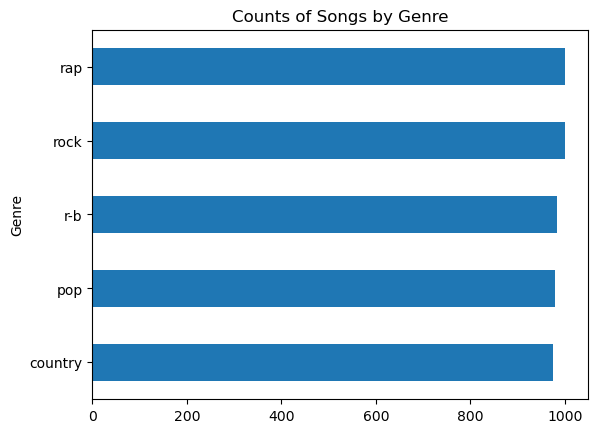

In [4]:
# Plot the total number of songs by genre
preproc_df_ungrouped["genre"].value_counts().sort_values(ascending = True).plot(
    kind = "barh",
    title = "Counts of Songs by Genre",
    xlabel = "Genre",
);

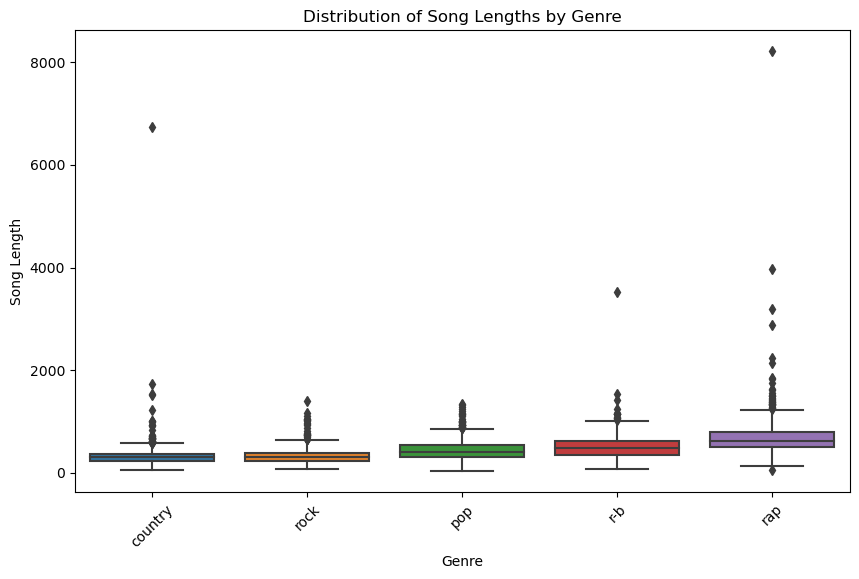

In [5]:
# Convert the 'genre' column to string representation
preproc_df_ungrouped["lyrics_length"] = preproc_df_ungrouped["lyrics"].apply(lambda x: len(x.split()))

#Plot distribution of song lengths by genre
plt.figure(figsize=(10, 6))
sns.boxplot(data=preproc_df_ungrouped, x="genre", y="lyrics_length")
plt.title("Distribution of Song Lengths by Genre")
plt.xlabel("Genre")
plt.ylabel("Song Length")
plt.xticks(rotation=45)
plt.show()


In [6]:
#identifying the format of genre column
unique_genres = preproc_df_ungrouped["genre"].unique()
print(unique_genres)


['country' 'rock' 'pop' 'r-b' 'rap']


Observe a few outliers which skew the distribution for country, r-b, and rap genres.

## Descriptive Statistics

In [7]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
   
    
    num_tokens = len(tokens) #length of tokens
    num_unique_tokens = (len(set(tokens))) #number of unique tokens
    lexical_diversity = (num_unique_tokens / num_tokens) #ratio of different unique word stems (types) to the total number of words (tokens).
    num_characters = sum(len(token) for token in tokens) #length of the string of tokens
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5)) #p. 16 of textbook
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [8]:
# Descriptive stats calculated for each all genres

# Iterate over each genre and calculate descriptive statistics
for genre in preproc_df_ungrouped["genre"].unique():
    genre_tokens = [token for tokens in preproc_df_ungrouped.loc[preproc_df_ungrouped["genre"] == genre, "tokens"] for token in tokens]
    print(f"Genre: {genre}")
    descriptive_stats(genre_tokens)
    print()

Genre: country
There are 156743 tokens in the data.
There are 16760 unique tokens in the data.
There are 778715 characters in the data.
The lexical diversity is 0.107 in the data.
[('know', 1660), ('****', 1450), ('love', 1316), ('got', 1196), ('might', 1193)]

Genre: rock
There are 149352 tokens in the data.
There are 15431 unique tokens in the data.
There are 751756 characters in the data.
The lexical diversity is 0.103 in the data.
[('know', 1800), ('****', 1787), ('love', 1452), ('might', 1139), ('got', 1122)]

Genre: pop
There are 194736 tokens in the data.
There are 19505 unique tokens in the data.
There are 953951 characters in the data.
The lexical diversity is 0.100 in the data.
[('****', 3460), ('know', 2659), ('love', 2434), ('got', 1831), ('get', 1540)]

Genre: r-b
There are 213327 tokens in the data.
There are 17143 unique tokens in the data.
There are 1031393 characters in the data.
The lexical diversity is 0.080 in the data.
[('****', 6146), ('know', 3949), ('love', 3174

# Build Word Cloud for each Genre

In [10]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column = 'tokens', preprocess = None, min_freq = 2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

The main 5 genres of interest are: country, rap, pop, rock, and R&B (r-b, as represented in the data).

In [11]:
# WordCloud Function
def make_wordcloud(genre):
    genre_subset = preproc_df_ungrouped.loc[preproc_df_ungrouped["genre"] == genre]
    genre_word_count = count_words(genre_subset)
    wordcloud(genre_word_count.squeeze(),
              title = "Genre: {}".format(genre))

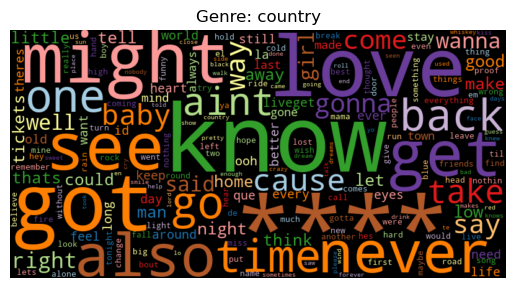

In [12]:
make_wordcloud("country")

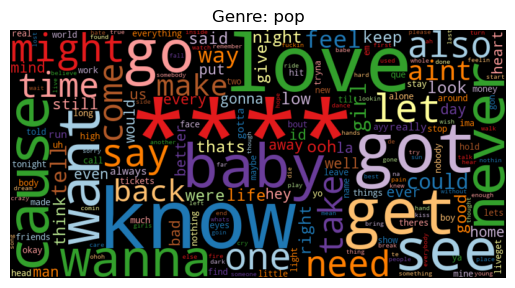

In [13]:
make_wordcloud("pop")

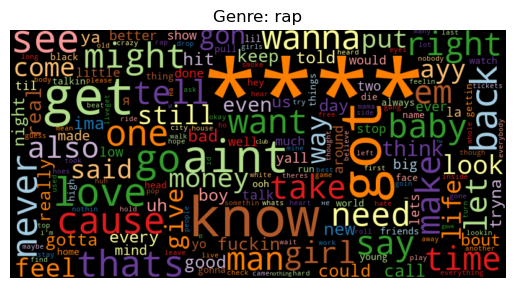

In [14]:
make_wordcloud("rap")

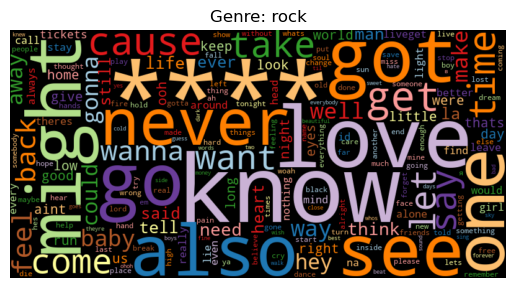

In [15]:
make_wordcloud("rock")

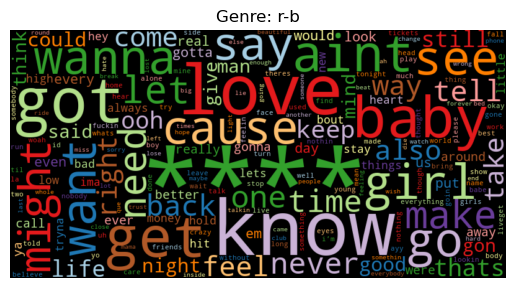

In [16]:
make_wordcloud("r-b")